*Highly Recommend opening this notebook on Google Colab. A number of Text cells will not show up on GitHub.*

⚠️ <a href="https://colab.research.google.com/github/AlaFalaki/workshop-materials/blob/main/2021-practical-deep-learning/04-Vision_Part2.ipynb"> Click Here To Open in Google Colab </a> ⚠️

# Practical Deep Learning Workshop (Part 4)

# PyTorch vs. FastAi (Vision)

Look closely at 3 main stages
  * Read the Data
  * Implement the Model
  * Training Loop


# Install FastAI2

> Run the cell below to install FastAI2. <br /><br />
> ⚠️ Make sure to restart the current runtime after the installation for changes to affect. Select 'Runtime' From the top menu and click on 'Restart Runtime'.

In [1]:
!pip install -Uq fastai

     |████████████████████████████████| 188 kB 8.8 MB/s 
     |████████████████████████████████| 53 kB 2.9 MB/s 


In [2]:
from fastai.vision.all import *

# Download the Data

> We are using a dataset called Flowers [1], which consists of images of flowers and their labels (102 different categories).

In [3]:
path = untar_data( URLs.FLOWERS, dest="./" )
path

Path('oxford-102-flowers')

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocess the Data

> Load the dataset using the Pandas DataFrame and look inside.

In [5]:
train_df = pd.read_csv(path/'train.txt', sep=' ', header=None, names=['link', 'label'])
test_df  = pd.read_csv(path/'test.txt' , sep=' ', header=None, names=['link', 'label'])
valid_df = pd.read_csv(path/'valid.txt', sep=' ', header=None, names=['link', 'label'])

In [6]:
train_df.head()

,link,label
0,jpg/image_03860.jpg,16
1,jpg/image_06092.jpg,13
2,jpg/image_02400.jpg,42
3,jpg/image_02852.jpg,55
4,jpg/image_07710.jpg,96


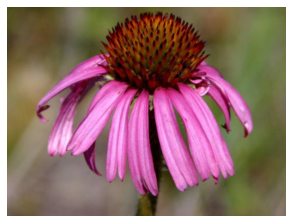

In [7]:
img = PILImage.create(path/train_df.iloc[0][0])
img.show()

> We can have access to all images and their labels from the created dataframes. Unfortunately, the dataset does not have human-readable labels. So, we need to download the labels from elsewhere. <br /> <br />
The labels come in a text file where each line contains one label. We can load a text file line-by-line with the following code:

In [8]:
!wget https://gist.githubusercontent.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1/raw/403325f5110cb0f3099734c5edb9f457539c77e9/Oxford-102_Flower_dataset_labels.txt

--2021-07-23 01:24:29--  https://gist.githubusercontent.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1/raw/403325f5110cb0f3099734c5edb9f457539c77e9/Oxford-102_Flower_dataset_labels.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘Oxford-102_Flower_dataset_labels.txt’

Oxford-102_Flower_d 100%[===================>]   1.57K  --.-KB/s    in 0s      

2021-07-23 01:24:29 (32.6 MB/s) - ‘Oxford-102_Flower_dataset_labels.txt’ saved [1608/1608]



In [9]:
class_labels = open('Oxford-102_Flower_dataset_labels.txt', 'r')
classes = class_labels.readlines()

label_names = []
for item in classes:
  label_names.append(item[2:-2])

In [10]:
label_names[:5]

['pink primrose',
 'hard-leaved pocket orchid',
 'canterbury bells',
 'sweet pea',
 'english marigold']

> Now, we can convert the label ids to human-readable labels so that FastAI takes care of encoding them to have one unified representation. It can convert them back to Ids on training time and back to strings to show the predicted labels.

In [11]:
train_df['label_name'] = train_df['label'].apply(lambda x: label_names[x])
test_df ['label_name'] = test_df ['label'].apply(lambda x: label_names[x])
valid_df['label_name'] = valid_df['label'].apply(lambda x: label_names[x])

In [12]:
train_df.head()

,link,label,label_name
0,jpg/image_03860.jpg,16,purple coneflower
1,jpg/image_06092.jpg,13,spear thistle
2,jpg/image_02400.jpg,42,sword lily
3,jpg/image_02852.jpg,55,bishop of llandaff
4,jpg/image_07710.jpg,96,mallow


In [13]:
print( "Train set: {} / Validation set: {} / Test set: {} ".format(len(train_df), len(valid_df), len(test_df)) )

Train set: 1020 / Validation set: 1020 / Test set: 6149 


> Because there is a huge imbalance in the number of samples on different sets. We can shuffle the data our own way.<br /><br />
⚠️ If you prepare a model for a competition or a study, you can not shuffle the data on your own. You need to follow specific guidelines.

In [14]:
tmp_train_df = train_df.copy()

train_df = test_df.copy()
valid_df = valid_df.copy()
test_df  = tmp_train_df.copy()

In [15]:
print( "Train set: {} / Validation set: {} / Test set: {} ".format(len(train_df), len(valid_df), len(test_df)) )

Train set: 6149 / Validation set: 1020 / Test set: 1020 


> New Train set = Test set <br />
New Test set = Train set <br /><br />
I did not make a separate validation set because FastAI can also take care of that for us.<br />
Let's load the data using the Dataloader.

In [16]:
img.shape

(500, 667)

# 1. Load the Data

## The PyTorch Way

> To load the data for PyTorch, we need to implement a class that inherits from PyTorch Dataset class (*from torch.utils.data import Dataset*), with at least these three functions:
 * __init __: responsible for initializing the class variables, and any kind of preprocessing.
 * __len __: It should only return the total number of rows in the data we are passing to it.
 * __getitem __: It will accept an index and return the data (image+label) from that index.

In [17]:
len(train_df)

6149

In [18]:
train_df.iloc[0]['link'], train_df.iloc[0]['label'], train_df.iloc[0]['label_name']

('jpg/image_06977.jpg', 34, 'alpine sea holly')

In [19]:
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import torch
import os

class FlowersDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_name = self.dataframe.iloc[index]['link']
        img      = Image.open(path/img_name).convert("RGB")
        label    = torch.tensor(float(self.dataframe.iloc[index]['label']))

        if self.transform is not None:
            img = self.transform(img)

        return (img, label)

> Next step is to define our list of transformations we want to perform on top of the data. Refer to [documentation](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py) for a list of transforms.

In [20]:
import torchvision.transforms as transforms

transform = transforms.Compose(
        [
            transforms.Resize((500, 500)),
            transforms.RandomCrop((250, 250)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

> Now, we will make a Dataset object for each one of the train/test/validation sets.

In [21]:
train_ds = FlowersDataset(train_df, transform=transform)
valid_ds = FlowersDataset(valid_df, transform=transform)
test_ds  = FlowersDataset(test_df , transform=transform)



> Lastly, use the PyTorch DataLoader class and pass our Dataset object. Dataloader will take care of batching and putting the data on the appropriate device (CPU/GPU).

In [22]:
shuffle      = True
batch_size  = 64
num_workers = 10

train_dl = DataLoader(train_ds, shuffle=shuffle,
                      batch_size=batch_size, num_workers=num_workers, device=device)
valid_dl = DataLoader(valid_ds, shuffle=shuffle,
                      batch_size=batch_size, num_workers=num_workers, device=device)
test_dl  = DataLoader(test_ds , shuffle=shuffle,
                      batch_size=batch_size, num_workers=num_workers, device=device)

> Print one batch from the Training set.

In [23]:
for batch in train_dl:
  print(batch[0].size())
  print(batch[1].size())
  
  print(batch)
  break

torch.Size([64, 3, 250, 250])
torch.Size([64])
(tensor([[[[ 1.0000,  1.0000,  1.0000,  ..., -0.1843, -0.2078, -0.2471],
          [ 0.9922,  1.0000,  1.0000,  ..., -0.2078, -0.2235, -0.2549],
          [ 0.9922,  1.0000,  1.0000,  ..., -0.2235, -0.2314, -0.2627],
          ...,
          [ 0.0431,  0.0118, -0.0196,  ..., -0.6078, -0.6000, -0.5922],
          [ 0.0275,  0.0118, -0.0353,  ..., -0.6392, -0.6314, -0.6078],
          [ 0.0275, -0.0039, -0.0510,  ..., -0.6784, -0.6627, -0.6392]],

         [[ 0.3255,  0.3412,  0.3490,  ..., -0.1059, -0.1216, -0.1608],
          [ 0.3098,  0.3412,  0.3412,  ..., -0.1294, -0.1373, -0.1686],
          [ 0.3098,  0.3333,  0.3412,  ..., -0.1451, -0.1451, -0.1765],
          ...,
          [-0.3098, -0.3098, -0.3255,  ..., -0.6549, -0.6392, -0.6314],
          [-0.3020, -0.3176, -0.3333,  ..., -0.6863, -0.6706, -0.6471],
          [-0.3020, -0.3176, -0.3412,  ..., -0.7255, -0.7098, -0.6784]],

         [[-1.0000, -0.9765, -0.9529,  ..., -0.5373, -

## The FastAi Way



> There are multiple ways to load data in FastAi. We went through a couple of examples in the past 3 sessions.<br />
The DataBlock API is by far the most flexible way to load the data in any library I've seen.<br />
For more info about it, go back to [Vision Part 1](https://colab.research.google.com/github/AlaFalaki/workshop-materials/blob/main/2021-practical-deep-learning/03-Vision_Part1.ipynb) notebook.<br /><br />
We just need to concatenate train/validation sets because FastAi can separate them for us.

In [24]:
train_df = pd.concat([train_df, valid_df], axis=0)

In [25]:
def get_x(x): return path/x['link']
def get_y(x): return x['label_name']

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=RandomSplitter(valid_pct=0.15, seed=42),
                   get_x=get_x,
                   get_y=get_y, 
                   item_tfms = Resize(500),
                   batch_tfms=aug_transforms(size=250)) 

In [27]:
dls = dblock.dataloaders( train_df )

In [28]:
len( dls.train_ds ), len( dls.valid_ds )

(6094, 1075)

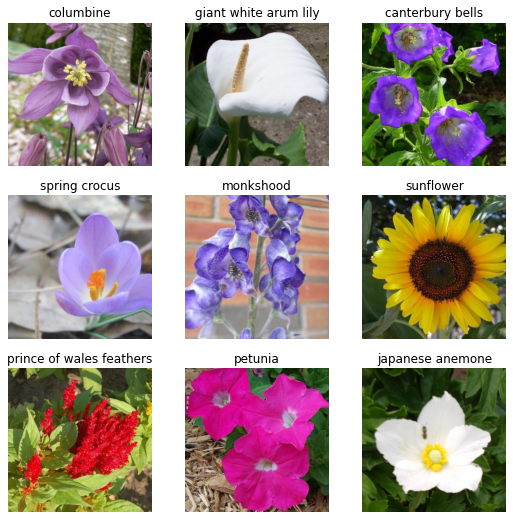

In [29]:
dls.show_batch()

# 2. Make the Model

## The PyTorch Way

> CNN [2] animated... 
  * kernel_size=3: The filter size is 3x3.
  * stride=1: The filter moves one pixel at a time.
  * padding = 0: There is no padding for the input here. (It will reduce the image dimension if we do not have padding)
  * The filter vector:

1|0|1
-|-|-
0|1|0
1|0|1

<center><img width="500" src="https://raw.githubusercontent.com/AlaFalaki/workshop-materials/main/2021-practical-deep-learning/materials/cnn.gif" /></center>
<center><small>Credit: Unkown</small></center>

> MaxPooling...

<center><img width="500" src="https://raw.githubusercontent.com/AlaFalaki/workshop-materials/main/2021-practical-deep-learning/materials/maxpool.gif" /></center>
<center><small>Credit: <a href="https://nico-curti.github.io/NumPyNet/NumPyNet/layers/maxpool_layer.html">NumPyNet</a></small></center>


> The whole model with the classification head and pooling layers.

<center><img width="700" src="https://raw.githubusercontent.com/AlaFalaki/workshop-materials/main/2021-practical-deep-learning/materials/cnn_model.jpeg" /></center>
<center><small>Credit: Unkown</small><center>

> We need to create a class that inherits from the PyTorch Module component for defining a custom model. It must have (at least) two functions.
  * __init __: set the layers/parameters of the network.
  * forward: it accepts an input (which is a batch of images in our case), and we can set the pass that the inputs should take in different layers.

In [30]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    
    self.first_block = nn.Sequential(
      nn.Conv2d(3, 12, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(12),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.second_block = nn.Sequential(
      nn.Conv2d(12, 24, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(24),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
    )

    self.linear_layers = nn.Sequential(
      nn.Linear(92256, len( dls.train_ds.vocab ))
    )

  def forward(self, x):
    x = self.first_block(x)
    x = self.second_block(x)
    x = x.view(x.size(0), -1)
    x = self.linear_layers(x)
    
    return x



---



> How to find out the number of features for each layer... Let's start with loading one batch of data as a sample input. Then, we can pass the input to the test layer and see what the output will look like.<br /><br />
⚠️ We already know that our dataset images have 3 channels (from img.shape output from one sample image in the dataset), so the first layer's number of input channels will be 3. For example, If we have a black and white image, the input channel would be 1.

In [31]:
x, y = dls.one_batch()

x.size()

torch.Size([64, 3, 250, 250])

> **1**. See first layer output size: (Increase the number of channels from 3 to 6)

In [33]:
first_layer = nn.Conv2d(3, 6, kernel_size=3, stride=1, padding=1).to(device)

first_layer_output = first_layer(x)

first_layer_output.size()

torch.Size([64, 6, 250, 250])

> **2**. See second layer output size: (Its input is going to be the first_layer_output and increase the number of channels from 6 to 12)

In [34]:
second_layer = nn.Conv2d(6, 12, kernel_size=3, stride=1, padding=1).to(device)

second_layer_output = second_layer(first_layer_output)

second_layer_output.size()

torch.Size([64, 12, 250, 250])

> **3.** Let's try adding one max_pooling layer. (It will reduce the image dimension)

In [36]:
max_pooling_layer = nn.MaxPool2d(kernel_size=2, stride=2).to(device)

max_pooled_output = max_pooling_layer( second_layer_output )

max_pooled_output.size()

torch.Size([64, 12, 125, 125])

> **4**. We can continue this process depending on how many layers we want our model to be. Then, we can see the final output's flattened size, which will be the last linear layer's input.

In [37]:
flattened_output = max_pooled_output.view(64, -1).to(device)

flattened_output.size()

torch.Size([64, 187500])

> **5**. The second dimension of above size 187500 (= 12 * 125 * 125) is the input of the linear layer to convert the flattened representation to the number of the labels (102 in our case). We can also call this layer **Classification head**. **This is the layer responsible for determining final prediction.**

In [38]:
classification_head = nn.Linear(187500, 102).to(device)

prediction = classification_head(flattened_output)

prediction.size()

torch.Size([64, 102])



---



# 3. Train the Model

> The training process is the same no matter what application we are working on. It always starts with choosing the loss function and optimizer to make the training loop and evaluation loop. Please read about it on [NLP Part 2](https://colab.research.google.com/github/AlaFalaki/workshop-materials/blob/main/2021-practical-deep-learning/02-NLP_Part2.ipynb) notebook.<br /><br />
Also, we already saw how to train and interpret a model in [NLP Part 2](https://colab.research.google.com/github/AlaFalaki/workshop-materials/blob/main/2021-practical-deep-learning/02-NLP_Part2.ipynb) and [Vision Part 1](https://colab.research.google.com/github/AlaFalaki/workshop-materials/blob/main/2021-practical-deep-learning/03-Vision_Part1.ipynb) notebook.

In [41]:
model = Model()

learn_fastai_pytorch = Learner(dls, model,
                               loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy,
                               opt_func=Adam, wd=None, moms=(0.95, 0.85, 0.95) 
                               )

In [42]:
learn_fastai_pytorch.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,16.899313,21.068848,0.141395,00:50
1,11.657101,7.208807,0.170233,00:50
2,5.955883,4.083992,0.294884,00:52
3,3.741250,3.331888,0.355349,00:50


# Workshop Resources

> The [Github Repository](https://github.com/AlaFalaki/workshop-materials/tree/main/2021-practical-deep-learning) contains all the notebooks and materials presented in this workshop.

# Free Resources

> You can watch these courses if you are more interested in NLP and want to learn the concepts with more details.

*   [FastAi course](https://course.fast.ai/)



# Question?

Do you have question regarding the materials? Feel free to contact me at **alamfal [at] uwindsor [dot] ca**

# Refrences

1. *Nilsback, M.-E, and A Zisserman. “A Visual Vocabulary for Flower Classification.” In 2006 IEEE Computer Society Conference on Computer Vision and Pattern Recognition (CVPR’06), 2:1447–1454. IEEE, 2006.*

2. *LeCun, Yann, Bernhard Boser, John Denker, Donnie Henderson, Richard Howard, Wayne Hubbard, and Lawrence Jackel. "Handwritten digit recognition with a back-propagation network." Advances in neural information processing systems 2 (1989).*